#### 文件读取

In [ ]:

f= open(filename, encoding='utf-8', errors='ignore')
        
        

def read_file(filename):
    """读取文件数据"""
    contents, labels = [], []
    with open_file(filename) as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(native_content(content)))
                    labels.append(native_content(label))
            except:
                pass
return contents, labels

### ROC曲线

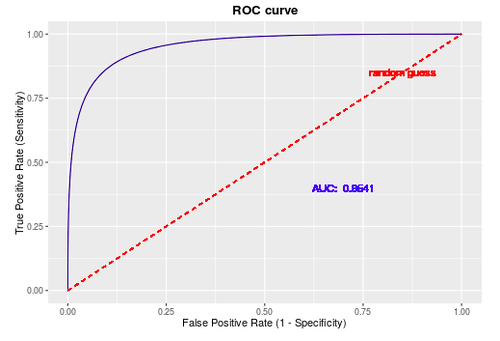

#### ROC曲线常用于二分类问题中的模型比较，主要表现为一种真正例率 (TPR) 和假正例率 (FPR) 的权衡。
具体方法是在不同的分类阈值 (threshold) 设定下分别以TPR和FPR为纵、横轴作图。
当一个样本被分类器判为正例，若其本身是正例，则TPR增加；若其本身是负例，则FPR增加，因此ROC曲线可以看作是随着阈值的不断移动，
所有样本中正例与负例之间的“对抗”。**曲线越靠近左上角，意味着越多的正例优先于负例，模型的整体表现也就越好。**





#### AUC (Area Under the Curve)




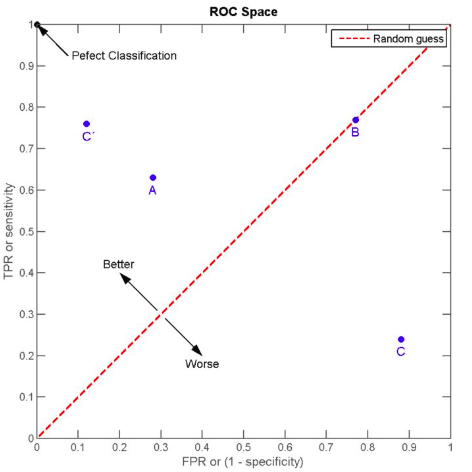

先看一下ROC曲线中的随机线，图中[0,0]到[1,1]的虚线即为随机线，该线上所有的点都表示该阈值下TPR=FPR，根据定义，TPR=TPPTPR=TPP，表示所有正例中被预测为正例的概率；FPR=FPNFPR=FPN，表示所有负例中被被预测为正例的概率。若二者相等，意味着无论一个样本本身是正例还是负例，分类器预测其为正例的概率是一样的，这等同于随机猜测（注意这里的“随机”不是像抛硬币那样50%正面50%反面的那种随机）。

上图中B点就是一个随机点，无论是样本数量和类别如何变化，始终将75%的样本分为正例。

ROC曲线围成的面积 (即AUC)可以解读为：从所有正例中随机选取一个样本A，再从所有负例中随机选取一个样本B，分类器将A判为正例的概率比将B判为正例的概率大的可能性。可以看到位于随机线上方的点(如图中的A点)被认为好于随机猜测。在这样的点上TPR总大于FPR，意为正例被判为正例的概率大于负例被判为正例的概率。

从另一个角度看，由于画ROC曲线时都是先将所有样本按分类器的预测概率排序，所以AUC反映的是分类器对样本的排序能力，依照上面的例子就是A排在B前面的概率。AUC越大，自然排序能力越好，即分类器将越多的正例排在负例之前。





#### ROC曲线的绘制方法：
假设有P个正例，N个反例，首先拿到分类器对于每个样本预测为正例的概率，根据概率对所有样本进行逆序排列，然后将分类阈值设为最大，即把所有样本均预测为反例，此时图上的点为 (0,0)。然后将分类阈值依次设为每个样本的预测概率，即依次将每个样本划分为正例，如果该样本为真正例，则TP+1，即TPR+1PTPR+1P; 如果该样本为负例，则FP+1，即FPR+1NFPR+1N。最后的到所有样本点的TPR和FPR值，用线段相连。


下面进行实现，先模拟生成一个正例：负例=10：1的数据集，用PCA降到2维进行可视化：




In [ ]:
X,y = make_classification(n_samples=2000, n_features=10, n_informative=4,
                         n_redundant=1, n_classes=2, n_clusters_per_class=1,
                         weights=[0.9,0.1], flip_y=0.1, random_state=2018)

sns.lmplot("pca_a","pca_b",data=X_pca, hue="y", fit_reg=False, markers=["o","x"],size=8,aspect=1.5,legend=False)
plt.legend(fontsize=20,bbox_to_anchor=(0.98, 0.6),edgecolor ='r')   
plt.xlabel("axis_1",fontsize=17)
plt.ylabel("axis_2",fontsize=17)




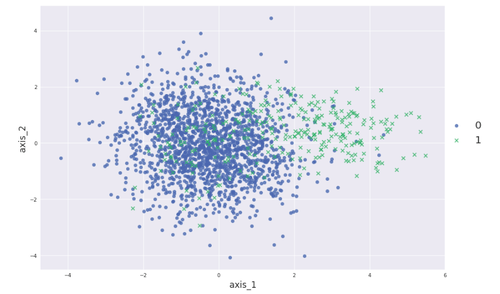

将数据分成训练集和测试集，使用Logistic Regression和Random Forest作图：





In [ ]:
kf = StratifiedKFold(n_splits=2, random_state=42)for train_index, test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
lr = LogisticRegression()
lr.fit(X_train,y_train)
pos_prob_lr = lr.predict_proba(X_test)[:,1]    # Logistic Regression的正例预测概率rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
pos_prob_rf = rf.predict_proba(X_test)[:,1]    # Random Forest的正例预测概率def get_roc(pos_prob,y_true):
    pos = y_true[y_true==1]
    neg = y_true[y_true==0]
    threshold = np.sort(pos_prob)[::-1]        # 按概率大小逆序排列
    y = y_true[pos_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                                  # 用于计算AUC
    for i in range(len(threshold)):        if y[i] == 1:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr    return tpr_all,fpr_all,y_sum*x_step         # 获得总体TPR，FPR和相应的AUCtpr_lr,fpr_lr,auc_lr = get_roc(pos_prob_lr,y_test)  
tpr_rf,fpr_rf,auc_rf = get_roc(pos_prob_rf,y_test)

plt.figure(figsize=(10,6))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
plt.plot(fpr_rf,tpr_rf,'g',label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)





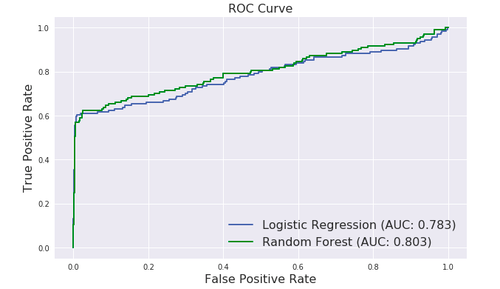

#### ROC曲线的优点




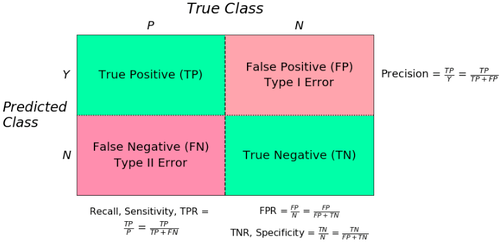

兼顾正例和负例的权衡。因为TPR聚焦于正例，FPR聚焦于与负例，使其成为一个比较均衡的评估方法。

ROC曲线选用的两个指标，TPR=TPP=TPTP+FNTPR=TPP=TPTP+FN，FPR=FPN=FPFP+TNFPR=FPN=FPFP+TN，都不依赖于具体的类别分布。

注意TPR用到的TP和FN同属P列，FPR用到的FP和TN同属N列，所以即使P或N的整体数量发生了改变，也不会影响到另一列。也就是说，即使正例与负例的比例发生了很大变化，ROC曲线也不会产生大的变化，而像Precision使用的TP和FP就分属两列，则易受类别分布改变的影响。

举了个例子，负例增加了10倍，ROC曲线没有改变，而PR曲线则变了很多。作者认为这是ROC曲线的优点，即具有鲁棒性，在类别分布发生明显改变的情况下依然能客观地识别出较好的分类器。




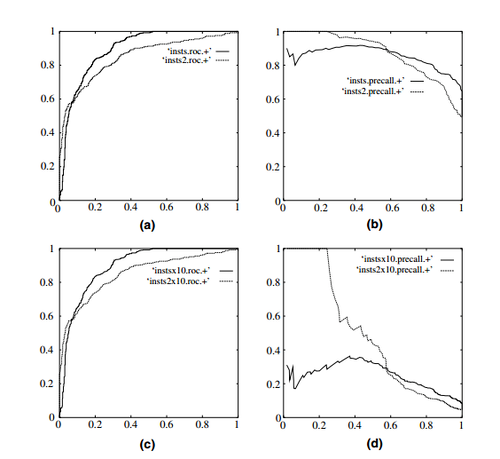

In [ ]:
X_test_dup = np.vstack((X_test,X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0]))
y_test_dup = np.array(y_test.tolist() + y_test[y_test==0].tolist()*9)   # 10x倍负例的测试集pos_prob_lr_dup = lr.predict_proba(X_test_dup)[:,1]
pos_prob_rf_dup = rf.predict_proba(X_test_dup)[:,1]
tpr_lr_dup,fpr_lr_dup,auc_lr_dup = get_roc(pos_prob_lr_dup,y_test_dup)
tpr_rf_dup,fpr_rf_dup,auc_rf_dup = get_roc(pos_prob_rf_dup,y_test_dup)

plt.figure(figsize=(10,6))
plt.plot(fpr_lr_dup,tpr_lr_dup,label="Logistic Regression (AUC: {:.3f})".format(auc_lr_dup),linewidth=2)
plt.plot(fpr_rf_dup,tpr_rf_dup,'g',label="Random Forest (AUC: {:.3f})".format(auc_rf_dup),linewidth=2)
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)




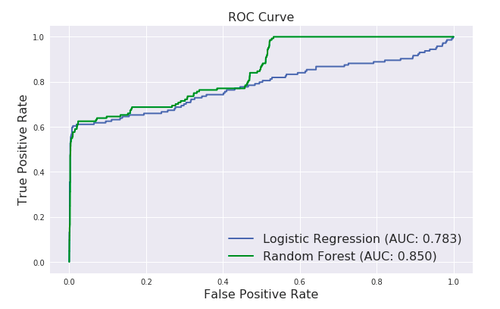

可以看到Logistic Regression的预测概率几乎没有重复，而Random Forest的预测概率则有很多重复，因为Logistic Regression可以天然输出概率，而Random Forest本质上属于树模型，只能输出离散值。scikit-learn中树模型的predict_proba() 方法表示的是一个叶节点上某一类别的样本比例，但只显示小数点后一位，致使大量样本的预测概率都一样。当画ROC曲线时需要先将样本根据预测概率排序，若几个样本的概率一样，则只能按原来的顺序排列。上面的操作就是将所有累加的负例都排在了原始数据后面，致使正例的顺序都很靠前，造成Random Forest的结果好了不少。解决办法就是将所有样本随机排序，就能产生和原来差不多的ROC曲线了：




#### ROC曲线的缺点

    上文提到ROC曲线的优点是不会随着类别分布的改变而改变，但这在某种程度上也是其缺点。因为负例N增加了很多，而曲线却没变，这等于产生了大量FP。像信息检索中如果主要关心正例的预测准确性的话，这就不可接受了。

    在类别不平衡的背景下，负例的数目众多致使FPR的增长不明显，导致ROC曲线呈现一个过分乐观的效果估计。ROC曲线的横轴采用FPR，根据FPR =FPNFPN=FPFP+TNFPFP+TN，当负例N的数量远超正例P时，FP的大幅增长只能换来FPR的微小改变。结果是虽然大量负例被错判成正例，在ROC曲线上却无法直观地看出来。（当然也可以只分析ROC曲线左边一小段）
    举个例子，假设一个数据集有正例20，负例10000，开始时有20个负例被错判，FPR=2020+9980=0.002FPR=2020+9980=0.002，接着又有20个负例错判，FPR2=4040+9960=0.004FPR2=4040+9960=0.004，在ROC曲线上这个变化是很细微的。而与此同时Precision则从原来的0.5下降到了0.33，在PR曲线上将会是一个大幅下降。




### PR (Precision Recall) 曲线

PR曲线展示的是Precision vs Recall的曲线，PR曲线与ROC曲线的相同点是都采用了TPR (Recall)，都可以用AUC来衡量分类器的效果。不同点是ROC曲线使用了FPR，而PR曲线使用了Precision，因此PR曲线的两个指标都聚焦于正例。类别不平衡问题中由于主要关心正例，所以在此情况下PR曲线被广泛认为优于ROC曲线。

PR曲线的绘制与ROC曲线类似，PR曲线的AUC面积计算公式为：

∑n(Rn−Rn−1)Pn∑n(Rn−Rn−1)Pn





In [ ]:
def get_pr(pos_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(pos_prob)[::-1]
    y = y_true[pos_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    auc = 0
    for i in range(len(threshold)):        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))    return precision,recall,auc

precision_lr,recall_lr,auc_lr = get_pr(pos_prob_lr,y_test)
precision_rf,recall_rf,auc_rf = get_pr(pos_prob_rf,y_test)

plt.figure(figsize=(10,6))
plt.plot(recall_lr,precision_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
plt.plot(recall_rf,precision_rf,label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision Recall Curve",fontsize=17)
plt.legend(fontsize=16)




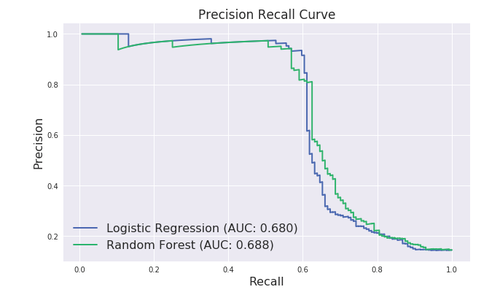

**可以看到上文中ROC曲线下的AUC面积在0.8左右，而PR曲线下的AUC面积在0.68左右，类别不平衡问题中ROC曲线确实会作出一个比较乐观的估计，而PR曲线则因为Precision的存在会不断显现FP的影响。**

#### 使用场景

    ROC曲线由于兼顾正例与负例，所以适用于评估分类器的整体性能，相比而言PR曲线完全聚焦于正例。

    如果有多份数据且存在不同的类别分布，比如信用卡欺诈问题中每个月正例和负例的比例可能都不相同，这时候如果只想单纯地比较分类器的性能且剔除类别分布改变的影响，则ROC曲线比较适合，因为类别分布改变可能使得PR曲线发生变化时好时坏，这种时候难以进行模型比较；反之，如果想测试不同类别分布下对分类器的性能的影响，则PR曲线比较适合。

    如果想要评估在相同的类别分布下正例的预测情况，则宜选PR曲线。

    类别不平衡问题中，ROC曲线通常会给出一个乐观的效果估计，所以大部分时候还是PR曲线更好。

    最后可以根据具体的应用，在曲线上找到最优的点，得到相对应的precision，recall，f1 score等指标，去调整模型的阈值，从而得到一个符合具体应用的模型。

原文出处：https://www.cnblogs.com/massquantity/p/8592091.html



